# Actor determination method 2: Based on operation dates
This notebook depicts the first methodology for actor determination as described in the corresponding master thesis. Threat reports are used as a basis for determining active threats and actors over a period in time.
The results of skimming the reports are denoted in a spreadsheet, which is scanned and used to count the precise occurences of these threats and actors across the reports. This data is then further enriched using public data sources. A graphical representation is depicted in the image below.

The enriched data can then be filtered on the sector and the actors and TTPs will be ranked using the ranking functions. These ranked TTPs are then mapped to controls in order to obtain a prioritization of security controls.

![Diagram representation of method 1](./docs/images/Method2.png)

## 1. Determine relevant threats  and actors
### 1.1. Read ETDA and MITRE data

<AxesSubplot:title={'center':'Operations over the years'}>

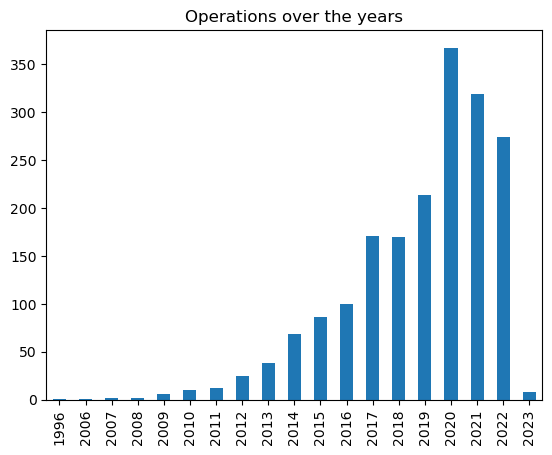

In [280]:
import datetime
import pandas as pd

SECTOR = 'Government'

YEAR = datetime.date.today().year
# YEAR = 2022
INTERVAL = 3
TTP_THRESHOLD = 0

import pandas as pd

merge_df = pd.read_json('ETDA_ATTCK_merge.json',encoding='utf-8')
# df = pd.DataFrame(merge_list)
merge_df['etda_operation_year'].explode().value_counts().sort_index().plot(kind='bar',title="Operations over the years")


#### 1.2. Preprocessing

In [281]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list if len(x) > 1]) # Convert column of lists to one list and remove single character values

agg_dict = {}
for column in merge_df.columns:
    if column == 'mitre_attack_ttps':
        agg_dict[column] = 'sum'
    else:
        agg_dict[column] = 'first'

merge_df = merge_df.groupby(['etda_name']).agg(agg_dict)
merge_df['mitre_attack_ttps'] = merge_df['mitre_attack_ttps'].apply(lambda x: pd.Series(x).unique())

C:\Users\a.winters\AppData\Local\Temp\ipykernel_18744\773326629.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  merge_df['mitre_attack_ttps'] = merge_df['mitre_attack_ttps'].apply(lambda x: pd.Series(x).unique())


#### 1.3. Filter on sector

<AxesSubplot:title={'center':'Operations within Government sector over the years'}>

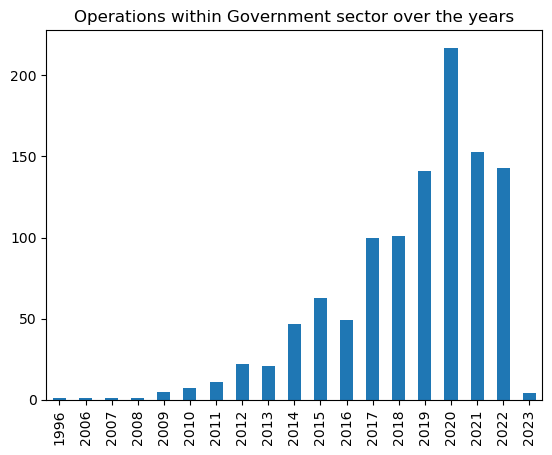

In [282]:
def filter_by_sector(df, sector):
    actors_sector_exploded = df.explode('victim_industries')
    return actors_sector_exploded.loc[actors_sector_exploded['victim_industries'] == sector]

actors_filtered = filter_by_sector(merge_df, SECTOR)
actors_filtered['etda_operation_year'].explode().value_counts().sort_index().plot(kind='bar',title="Operations within {} sector over the years".format(SECTOR))

#### Observation
How is the date derived? Date of reported breach, or date of actual breach.

Are reports relevant? 

#### 1.4. Count number of recent operations
Remove actors with no operations

<AxesSubplot:title={'center':'Top 5 actors targeting Government sector based on operations between 2020 and 2023'}, ylabel='Actor'>

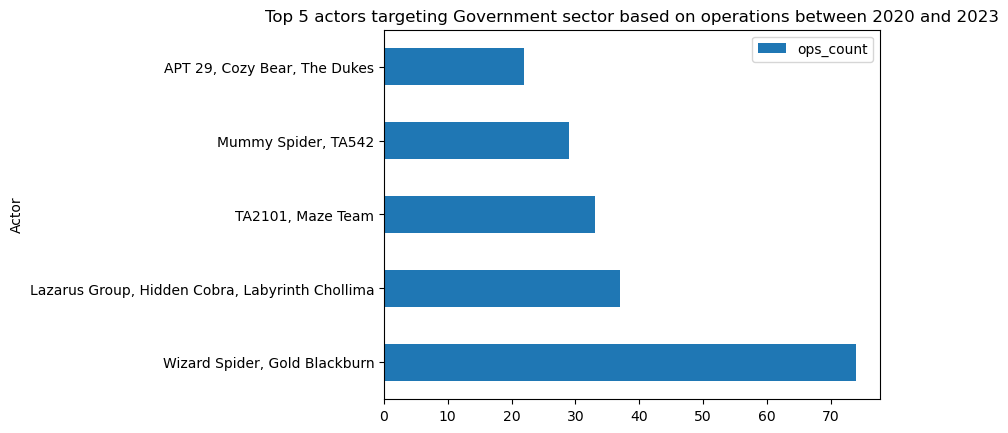

In [283]:
def filter_by_operation_year(df, interval):
    years = list(range((YEAR-interval),YEAR+1))
    years = [str(i) for i in years]
    df['etda_operation_year'] = df['etda_operation_year'].apply(lambda x: [i for i in x if i in years])
    return df

actors_filtered = filter_by_operation_year(actors_filtered, INTERVAL)    
actors_filtered['ops_count'] = actors_filtered['etda_operation_year'].apply(len)
actors_filtered = actors_filtered.loc[actors_filtered['ops_count']>0].sort_values(by='ops_count',ascending=False)
actors_filtered.nlargest(5,'ops_count').plot(kind='barh',x='etda_name',xlabel='Actor',ylabel='Number of registered operations',title="Top 5 actors targeting {} sector based on operations between {} and {}".format(SECTOR,YEAR-INTERVAL,YEAR))

In [284]:
actors_filtered['etda_name'].size

73

## 2. Rank actors and TTPs
### 2.1 Rank actors
#### 2.1.1 Create weight and sort
TODO: Define weight calculation

In [285]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

actors_filtered['actor_weight'] = normalize(actors_filtered['ops_count'])

actors_filtered.sort_values(by='actor_weight',ascending=False)

actors_ranked = actors_filtered[['actor_weight','mitre_attack_ttps']]
unique_ttps = to_1D(actors_ranked['mitre_attack_ttps']).value_counts()

print('Number of actors:',actors_ranked.index.size)
print('Number of TTPs:\t', unique_ttps.index.size)

Number of actors: 73
Number of TTPs:	 332


<AxesSubplot:title={'center':'Top 5 actors targeting Government sector based on operations between 2020 and 2023 (normalized)'}, ylabel='Actor Name'>

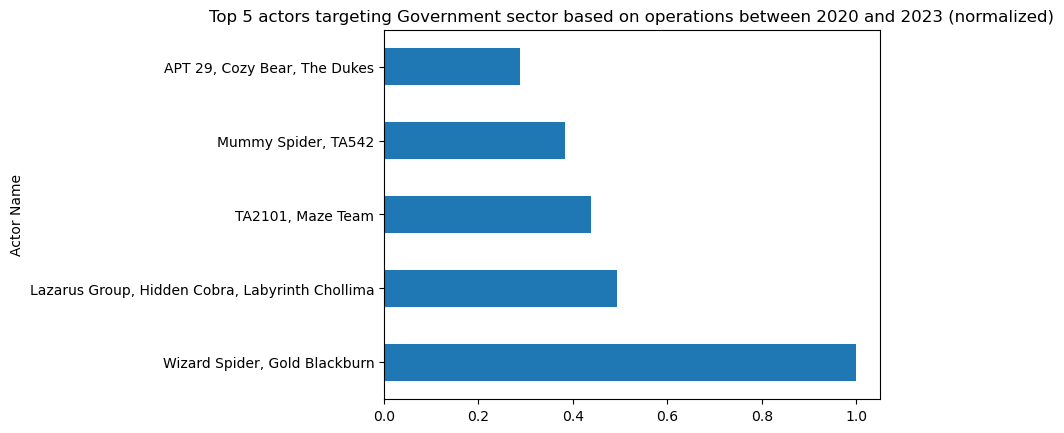

In [286]:
actor_weights = actors_ranked['actor_weight']
actor_weights.nlargest(5).plot(kind='barh',xlabel='Actor Name', title="Top 5 actors targeting {} sector based on operations between {} and {} (normalized)".format(SECTOR,YEAR-INTERVAL,YEAR))

In [287]:
actors_ranked

,actor_weight,mitre_attack_ttps
etda_name,,
"Wizard Spider, Gold Blackburn",1.000000,"[T1070.004, T1557.001, T1543.003, T1003.002, T..."
"Lazarus Group, Hidden Cobra, Labyrinth Chollima",0.493151,"[T1573.001, T1070.003, T1588.002, T1560.002, T..."
"TA2101, Maze Team",0.438356,[Not Available]
"Mummy Spider, TA542",0.383562,[Not Available]
"APT 29, Cozy Bear, The Dukes",0.287671,"[T1078.004, T1001.002, T1087, T1562.004, T1560..."
...,...,...
Mikroceen,0.000000,[Not Available]
Moses Staff,0.000000,"[T1105, T1587.001, T1087.001, T1505.003, T1588..."
"Naikon, Lotus Panda",0.000000,"[T1046, T1547.001, T1137.006, T1518.001, T1047..."


#### Observations
Since the Government sector is the most represented in the ETDA dataset, this one is chosen for the tests. 13 of the actors from the reports target this sector. APT 29 is mentioned the most across reports. This is due to their notorious SolarWinds attack in 2020, which is mentioned often. In 2021 they also launched a big spear-phishing campaign. This actor is followed by Wizard Spider, a ransomware actor that is very active.

It is mainly these two actors that exceed the others in terms of how often they are mentioned. The other mentioned actors have a weigth just below 1.0.

### 2.2. Rank TTPs
#### 2.3.1 Explode dataframe per TTP
Explode the dataframe per TTP. Now a weighting calculation can be done per TTP, based on the information provided. Information includes the actor results (and kill chain phase).

For now: the actor weights are summed per TTP to obtain a ranking per TTP. 

In [288]:
actors_ttp_exploded = actors_ranked.explode('mitre_attack_ttps')

#### 2.3.2. Group by TTP and sum actor weights
Sum the actor weights.

In [289]:
actors_ttp_summed = actors_ttp_exploded.reset_index(drop=True)
ttps_ranked = actors_ttp_summed.groupby('mitre_attack_ttps').sum()
ttps_ranked.sort_values(by='actor_weight',ascending=False)

,actor_weight
mitre_attack_ttps,
T1027,4.232877
T1059.003,4.123288
T1204.002,4.068493
T1566.001,3.876712
T1059.001,3.876712
...,...
T1595.003,0.000000
T1102.003,0.000000
T1587.002,0.000000


#### 2.3.3 Enrich TTP information
Information from the ATT&CK data is used via the attackcti package.

In [290]:
from attackcti import attack_client
from pandas import json_normalize
import sys

mitre_columns = ['technique_id','technique','kill_chain_phases','id','tactic','technique_detection','impact_type']

def get_attck_dataframe(matrix = 'enterprise'):
    if  (matrix.lower() == 'enterprise'):
        # Instantiating attack_client class
        lift = attack_client()
        # Getting techniques for windows platform - enterprise matrix
        attck = lift.get_enterprise_techniques(stix_format = False)
        # Generating a dataframe with information collected
        attck = json_normalize(attck)
        return attck
    else:
        sys.exit('ERROR: Only Enterprise available!!')

attck = get_attck_dataframe()
attck = attck[mitre_columns]

ttps_enriched = pd.merge(ttps_ranked,attck,how='left',left_index=True,right_on='technique_id')
ttps_enriched.index = ttps_ranked.index
ttps_enriched['technique_name_id'] = ttps_enriched['technique'] + " (" + ttps_enriched['technique_id'] + ")"

[taxii2client.v20] [WARNING ] [2023-05-03 10:42:55,692] TAXII Server Response did not include 'Content-Range' header - results could be incomplete.
[taxii2client.v20] [WARNING ] [2023-05-03 10:42:55,710] TAXII Server Response with different amount of objects! Setting per_request=750


#### 2.3.4. Calculate weights

In [291]:
ttps_enriched['ttp_weight'] = normalize(ttps_enriched['actor_weight'])
ttps_enriched = ttps_enriched.drop(['actor_weight'],axis=1)

#### Statistics

<AxesSubplot:ylabel='Frequency'>

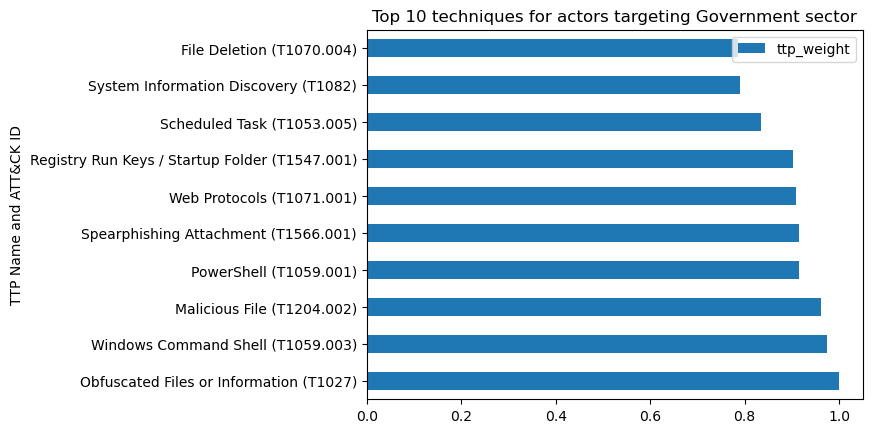

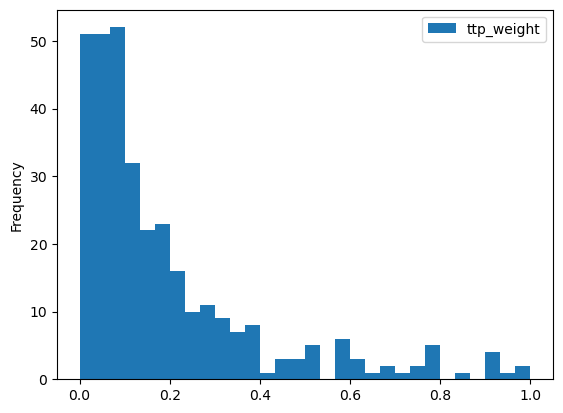

In [292]:
ttps_enriched.nlargest(10,columns='ttp_weight').plot.barh(y='ttp_weight',x='technique_name_id',xlabel="TTP Name and ATT&CK ID" ,title="Top 10 techniques for actors targeting {} sector".format(SECTOR))

ttps_enriched.plot.hist(column="ttp_weight",bins=30)

Only take the top percentage of the TTPs

In [293]:
PERCENTAGE = 0.8

top_percent = int(len(ttps_enriched) * PERCENTAGE)

print(top_percent)

ttps_enriched = ttps_enriched.nlargest(top_percent,columns="ttp_weight")

265


#### Observations
Within the tested Government sector, the top 10 techniques used are shown above. 
The top technique is '[Obfuscated Files or Information](https://attack.mitre.org/techniques/T1027/)', where adversaries obfuscate the contents of an executable or file by encrypting, encoding, compressing or otherwise obscuring them on the system or in transit. This is common behavior to evade defenses. 

The second technique is '[Tool]'(https://attack.mitre.org/techniques/T1588/002/), is described as "Adversaries may buy, steal or download software tools that can be used during targeting." This is a very generic technique, since the use of the use of tools is common among hackers and there exists a wide variety of tools, hence why it is listed in such a high position.

## 3. Control prioritization

### 3.1 Control Mapping
Source of the mapping: [Security Control Framework Mappings to ATT&CK](https://github.com/center-for-threat-informed-defense/attack-control-framework-mappings).

This maps controls from NIST 800-53 to MITRE ATT&CK. The following versions are considered:
- MITRE ATT&CK v10.1
- NIST 800-53 Revision 5

In [294]:
# Load ATT&CK to NIST 800-53 mapping
nist_attck_mapping = pd.read_excel("data/mappings/nist800-53-r5-mappings.xlsx")
nist_attck_mapping = nist_attck_mapping.drop(["Mapping Type","Technique Name"],axis=1)

Merge the TTPs with the controls. Only keep the TTPs that have a weight above a certain threshold. This threshold will be experimented with. The following values are considered:
- All TTPs
- threshold > 0.25
- threshold > 0.5
- threshold > 0.7
- threshold > 0.9

In [295]:
ttp_control_merge = nist_attck_mapping.merge(ttps_enriched, left_on="Technique ID", right_on="technique_id")
# ttp_control_merge = ttp_control_merge.loc[ttp_control_merge['ttp_weight']>TTP_THRESHOLD]
ttp_control_merge.sort_values(by='ttp_weight',inplace=True,ascending=False)
print("Number of TTPS:",ttp_control_merge['Technique ID'].value_counts().index.size)
print("Number of controls:",ttp_control_merge['Control ID'].value_counts().index.size)
ttp_control_merge

Number of TTPS: 175
Number of controls: 101


,Control ID,Control Name,Technique ID,technique_id,technique,kill_chain_phases,id,tactic,technique_detection,impact_type,technique_name_id,ttp_weight
2038,CM-2,Baseline Configuration,T1027,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),1.000000
2040,SI-2,Flaw Remediation,T1027,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),1.000000
2041,SI-3,Malicious Code Protection,T1027,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),1.000000
2042,SI-4,System Monitoring,T1027,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),1.000000
2043,SI-7,"Software, Firmware, and Information Integrity",T1027,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
406,AC-20,Use of External Systems,T1557,T1557,Adversary-in-the-Middle,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--035bb001-ab69-4a0b-9f6c-2de8b0...,"[credential-access, collection]",Monitor network traffic for anomalies associat...,NaN,Adversary-in-the-Middle (T1557),0.038835
407,AC-3,Access Enforcement,T1557,T1557,Adversary-in-the-Middle,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--035bb001-ab69-4a0b-9f6c-2de8b0...,"[credential-access, collection]",Monitor network traffic for anomalies associat...,NaN,Adversary-in-the-Middle (T1557),0.038835
408,AC-4,Information Flow Enforcement,T1557,T1557,Adversary-in-the-Middle,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--035bb001-ab69-4a0b-9f6c-2de8b0...,"[credential-access, collection]",Monitor network traffic for anomalies associat...,NaN,Adversary-in-the-Middle (T1557),0.038835
409,CA-7,Continuous Monitoring,T1557,T1557,Adversary-in-the-Middle,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--035bb001-ab69-4a0b-9f6c-2de8b0...,"[credential-access, collection]",Monitor network traffic for anomalies associat...,NaN,Adversary-in-the-Middle (T1557),0.038835


<AxesSubplot:title={'center':'Top controls by number of mitigated TTPs. Top 80.0% of TTPS'}, ylabel='Control ID,Control Name'>

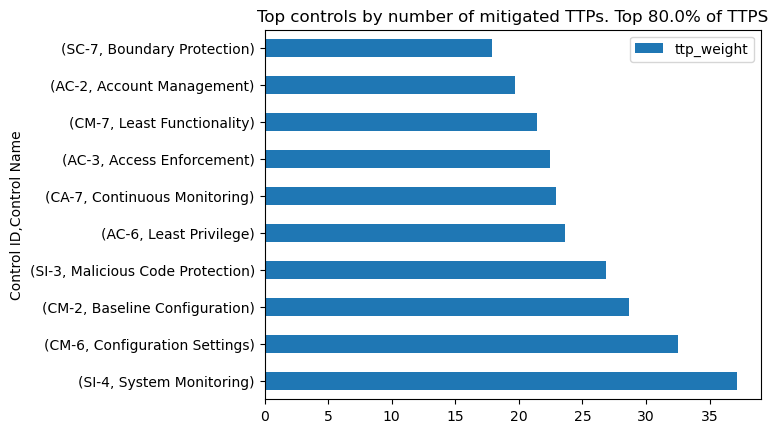

In [296]:
# ttp_control_merge[['Control ID','Control Name']].value_counts().nlargest(10).plot(kind='barh',title="Number of selected TTPs mitigated per control")

ttp_control_ranked = ttp_control_merge.groupby(['Control ID','Control Name']).sum()
ttp_control_ranked.sort_values(by='ttp_weight',ascending=False)

# ttp_control_ranked.nlargest(10,columns='ttp_weight').plot(kind='barh',title="Top controls by number of mitigated TTPs. No TTP threshold")
ttp_control_ranked.nlargest(10,columns='ttp_weight').plot(kind='barh',title="Top controls by number of mitigated TTPs. Top {}% of TTPS".format(PERCENTAGE*100))

#### Observations
There are some controls that map to a lot of TTPs. This results in a large set of TTP-Control mappings. Since there is no measure of control effectiveness to a TTP in this data, they can currently only be sorted based on the TTPs they control and their respective weights.

There are two ways to approach the ranking, either TTP based on Control based:
- TTP: Take the most prominent TTPs, which are ranked, and show the controls for this
- Control: Rank the controls based on the number of TTPs they control and their respective weights. The downside of this is that controls that map to a large number of TTPs will probably always end up on top. This means that the initial TTP ranking matters less.


When simply counting the number of TTPs that a control covers, only the general ones come to the top. Even if the TTP weights are considered. One possibility to solve this, is to only take the top x% of TTPs into consideration.

In thesis: put 3 graphs side by side, showing difference in taking the top x% of TTPs. Discuss what is best, a generic approach or a targeted approach.